In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# --- Robust data loader for the repo file ---
# Goal: always load data/raw/health_dataset.csv (or data/health_dataset.csv) from the current git repo,
# regardless of where VS Code/Jupyter sets the working directory.

from pathlib import Path
import pandas as pd

def find_repo_root_with_data(start: Path) -> Path:
    """
    Search upward from `start` until we find a directory containing
    either data/raw/health_dataset.csv or data/health_dataset.csv. Works in VS Code notebooks even when CWD is odd.
    """
    start = start.resolve()
    candidates = [Path("data") / "raw" / "health_dataset.csv", Path("data") / "health_dataset.csv"]
    for p in [start] + list(start.parents):
        for candidate in candidates:
            if (p / candidate).exists():
                return p
    raise FileNotFoundError(
        "Cannot locate repo root containing data/raw/health_dataset.csv or data/health_dataset.csv.\n"
        f"Start location was: {start}\n"
        "Fix: open the repo root as your VS Code workspace, or run the notebook from within the repo."
    )

REPO_ROOT = find_repo_root_with_data(Path.cwd())
# Prefer the raw/ path if present, otherwise fall back to data/health_dataset.csv
if (REPO_ROOT / "data" / "raw" / "health_dataset.csv").exists():
    DATA_PATH = REPO_ROOT / "data" / "raw" / "health_dataset.csv"
else:
    DATA_PATH = REPO_ROOT / "data" / "health_dataset.csv"

print("REPO_ROOT:", REPO_ROOT)
print("Loading:", DATA_PATH)

# Load the CSV
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

df.head()


REPO_ROOT: /Users/young/551/milestone/551Grp2
Loading: /Users/young/551/milestone/551Grp2/data/raw/health_dataset.csv
Shape: (108252, 50)


,ADM_RNO1,Province,Health_region_ grouped,Gender,Marital_status,Household,Age,Worked_job_business,Edu_level,Gen_health_state,...,Physical_vigorous_act_time,Work_hours,working_status,Aboriginal_identity,Birth_country,Immigrant,Insurance_cover,Food_security,Income_source,Total_income
0,1000,47,47906,2,1,2,3,1,3,3,...,10,38,1,2,1,2,1,0,1,5
1,100005,47,47906,1,1,2,5,6,2,3,...,0,96,6,2,1,2,1,0,2,4
2,100012,59,59914,2,2,1,5,6,1,2,...,9996,96,6,2,1,2,6,6,2,2
3,100015,13,13904,1,2,1,5,6,1,3,...,9996,96,6,2,1,2,6,0,2,3
4,100018,46,46903,1,2,1,4,2,3,5,...,9996,96,6,2,1,2,2,0,2,1


In [3]:
# Core outcomes
OUTCOMES = ["Stress_level", "Mental_health_state", "Life_satisfaction"]

# Demographics / grouping variables
GROUPS = ["Age", "Gender", "Province"]

# Lifestyle / behaviors
BEHAVIORS = ["Total_physical_act_time", "Physical_vigorous_act_time", "Fruit_veg_con"]

# Chronic condition flags
CHRONIC = ["High_BP", "Diabetic", "Mood_disorder", "Anxiety_disorder"]

cols = [c for c in (OUTCOMES + GROUPS + BEHAVIORS + CHRONIC) if c in df.columns]
missing_cols = sorted(set(OUTCOMES + GROUPS + BEHAVIORS + CHRONIC) - set(cols))
print("Using columns:", cols)
print("Missing columns (check spelling):", missing_cols)

d = df[cols].copy()
d.head()


Using columns: ['Stress_level', 'Mental_health_state', 'Life_satisfaction', 'Age', 'Gender', 'Province', 'Total_physical_act_time', 'Physical_vigorous_act_time', 'Fruit_veg_con', 'High_BP', 'Diabetic', 'Mood_disorder', 'Anxiety_disorder']
Missing columns (check spelling): []


,Stress_level,Mental_health_state,Life_satisfaction,Age,Gender,Province,Total_physical_act_time,Physical_vigorous_act_time,Fruit_veg_con,High_BP,Diabetic,Mood_disorder,Anxiety_disorder
0,2,3,9,3,2,47,0,10,1.3,2,2,2,2
1,3,3,4,5,1,47,0,0,1.0,1,2,1,2
2,3,3,7,5,2,59,9996,9996,9999.6,1,1,2,2
3,3,3,8,5,1,13,9996,9996,9999.6,1,2,2,2
4,4,5,0,4,1,46,9996,9996,9999.6,1,9,2,2


In [4]:
SPECIAL_CODES = {
    96, 97, 98, 99,
    996, 997, 998, 999,
    9996, 9997, 9998, 9999,
    99996, 99997, 99998, 99999
}

def replace_special_codes(series: pd.Series) -> pd.Series:
    # Only attempt replacement for numeric-like columns
    if pd.api.types.is_numeric_dtype(series):
        return series.where(~series.isin(SPECIAL_CODES), np.nan)
    return series

for c in d.columns:
    d[c] = replace_special_codes(d[c])

d.describe(include="all").T.head(20)


,count,mean,std,min,25%,50%,75%,max
Stress_level,108252.0,2.595324,1.060638,1.0,2.0,3.0,3.0,8.0
Mental_health_state,108252.0,2.381148,1.562486,1.0,1.0,2.0,3.0,9.0
Life_satisfaction,104052.0,8.057808,1.687106,0.0,7.0,8.0,9.0,10.0
Age,108252.0,3.825324,1.293388,1.0,3.0,4.0,5.0,5.0
Gender,108252.0,1.544729,0.497998,1.0,1.0,2.0,2.0,2.0
Province,108252.0,34.405683,15.260020,10.0,24.0,35.0,47.0,60.0
Total_physical_act_time,20684.0,90.156691,234.497923,0.0,0.0,0.0,120.0,10080.0
Physical_vigorous_act_time,20396.0,31.551432,167.631055,0.0,0.0,0.0,0.0,8400.0
Fruit_veg_con,108252.0,7605.941255,4265.787233,0.0,9999.6,9999.6,9999.6,9999.9
High_BP,108252.0,1.747894,0.552019,1.0,1.0,2.0,2.0,8.0


In [5]:
miss = pd.DataFrame({
    "missing_n": d.isna().sum(),
    "missing_pct": (d.isna().mean() * 100).round(2),
    "n_unique": d.nunique(dropna=True)
}).sort_values("missing_pct", ascending=False)

display(miss)


,missing_n,missing_pct,n_unique
Physical_vigorous_act_time,87856,81.16,154
Total_physical_act_time,87568,80.89,206
Life_satisfaction,4200,3.88,11
Stress_level,0,0.00,7
Mental_health_state,0,0.00,8
Age,0,0.00,5
Gender,0,0.00,2
Province,0,0.00,11
Fruit_veg_con,0,0.00,193
High_BP,0,0.00,4


In [6]:
for col in [c for c in OUTCOMES if c in d.columns]:
    vc = d[col].value_counts(dropna=False).head(30)
    display(pd.DataFrame({col: vc.index, "count": vc.values}))


,Stress_level,count
0,3,40711
1,2,29404
2,1,18893
3,4,16012
4,5,2803
5,7,380
6,8,49


,Mental_health_state,count
0,2,38829
1,1,30394
2,3,26551
3,4,6955
4,9,3552
5,5,1784
6,7,145
7,8,42


,Life_satisfaction,count
0,8.0,32001
1,10.0,22971
2,9.0,19835
3,7.0,15019
4,5.0,5566
5,6.0,5426
6,NaN,4200
7,4.0,1297
8,3.0,785
9,0.0,471


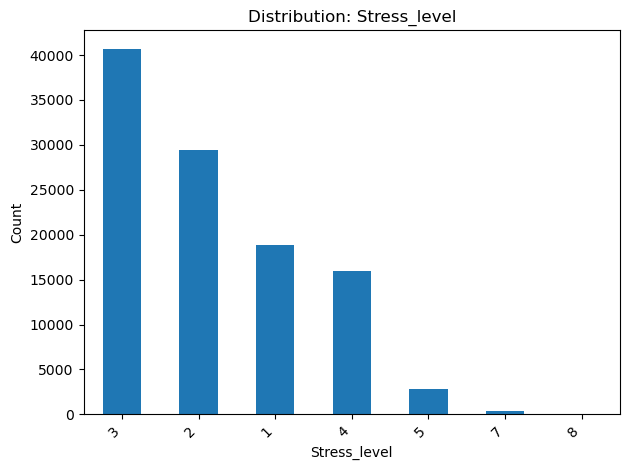

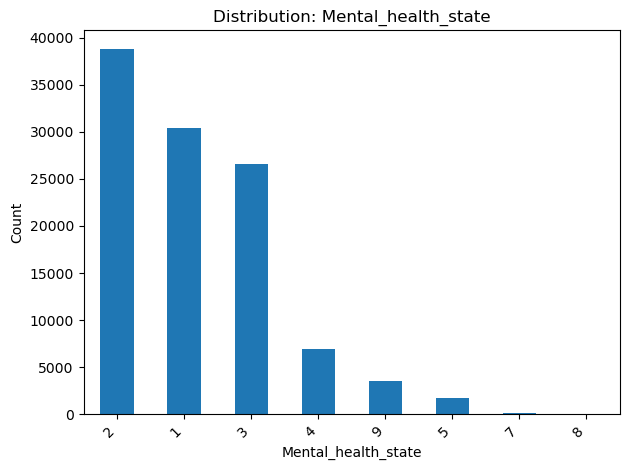

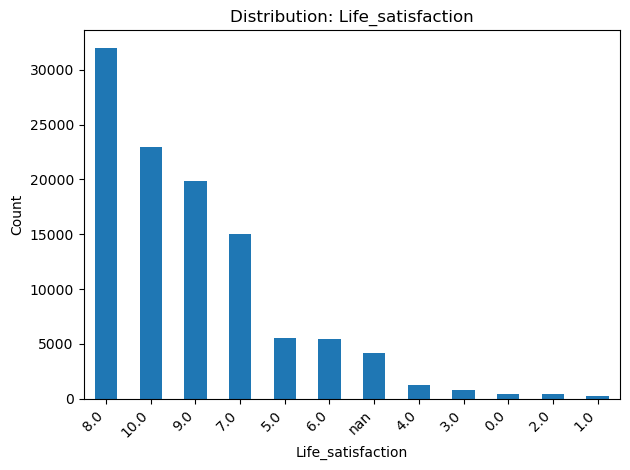

In [7]:
for col in [c for c in OUTCOMES if c in d.columns]:
    counts = d[col].value_counts(dropna=False)
    plt.figure()
    counts.plot(kind="bar")
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


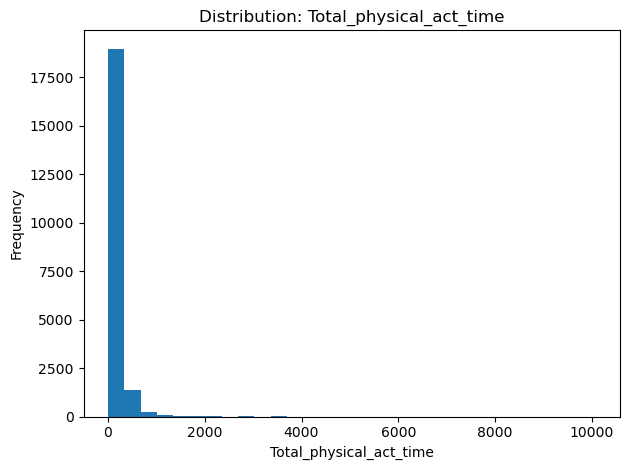

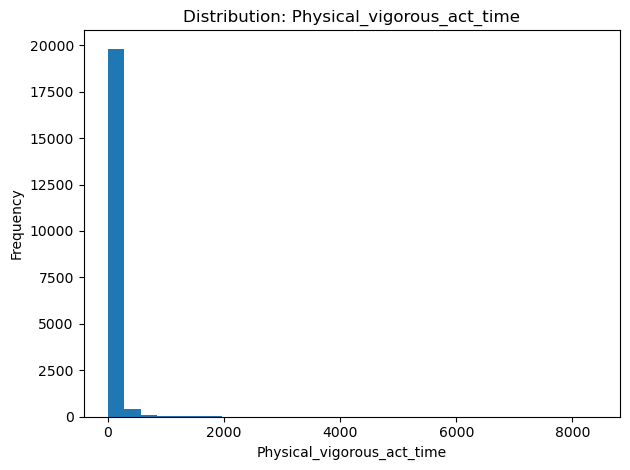

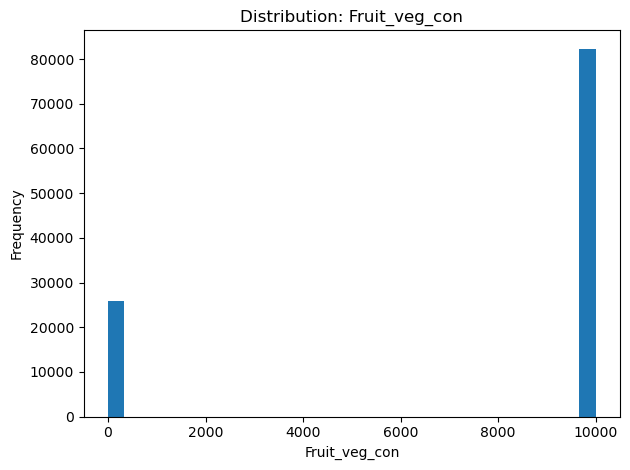

In [8]:
for col in [c for c in BEHAVIORS if c in d.columns]:
    plt.figure()
    d[col].dropna().plot(kind="hist", bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [9]:
rows = []
for col in [c for c in CHRONIC if c in d.columns]:
    # Try to treat as binary if possible
    s = d[col].dropna()
    if s.empty:
        continue
    # If values look like 0/1, compute prevalence of 1
    vals = set(s.unique())
    if vals.issubset({0, 1}):
        prev = float((s == 1).mean())
        rows.append((col, prev, len(s)))
    else:
        # Otherwise show top value counts
        vc = s.value_counts().head(10)
        print(f"\nTop values for {col}:")
        display(vc)

prev_df = pd.DataFrame(rows, columns=["condition", "prevalence_of_1", "n_non_missing"])
display(prev_df.sort_values("prevalence_of_1", ascending=False))



Top values for High_BP:


High_BP
2    78485
1    29359
7      380
8       28
Name: count, dtype: int64


Top values for Diabetic:


Diabetic
2    95749
1     9838
9     2529
7      112
8       24
Name: count, dtype: int64


Top values for Mood_disorder:


Mood_disorder
2    97793
1    10258
7      159
8       42
Name: count, dtype: int64


Top values for Anxiety_disorder:


Anxiety_disorder
2    97860
1    10170
7      178
8       44
Name: count, dtype: int64

,condition,prevalence_of_1,n_non_missing


In [10]:
outcome = "Stress_level"
if outcome in d.columns and all(x in d.columns for x in ["Age", "Gender"]):
    tab = (
        d.dropna(subset=[outcome, "Age", "Gender"])
         .groupby(["Age", "Gender"])[outcome]
         .value_counts(normalize=False)
         .rename("count")
         .reset_index()
    )
    display(tab.head(30))

    # Show sample size by segment (to detect sparse groups)
    seg_n = (
        d.dropna(subset=[outcome, "Age", "Gender"])
         .groupby(["Age", "Gender"])
         .size()
         .reset_index(name="n")
         .sort_values("n")
    )
    display(seg_n.head(20))


,Age,Gender,Stress_level,count
0,1,1,2,1220
1,1,1,3,1129
2,1,1,1,681
3,1,1,4,253
4,1,1,5,33
5,1,1,7,9
6,1,1,8,1
7,1,2,3,1281
8,1,2,2,943
9,1,2,4,473


,Age,Gender,n
1,1,2,3173
0,1,1,3326
2,2,1,7128
4,3,1,7692
3,2,2,8149
5,3,2,9133
6,4,1,10219
7,4,2,11465
8,5,1,20919
9,5,2,27048


In [11]:
import numpy as np

# --- Mappings from codebook ---
MAP_AGE = {
    1: "12–17",
    2: "18–34",
    3: "35–49",
    4: "50–64",
    5: "65+",
}

MAP_GENDER = {
    1: "Male",
    2: "Female",
    9: "Not stated",
}

MAP_STRESS = {
    1: "Not at all",
    2: "Not very",
    3: "A bit",
    4: "Quite a bit",
    5: "Extremely",
    7: "Don't know",
    8: "Refusal",
}

MAP_MENTAL = {
    1: "Excellent",
    2: "Very good",
    3: "Good",
    4: "Fair",
    5: "Poor",
    7: "Don't know",
    8: "Refusal",
    9: "Not stated",
}

MAP_FRUIT_VEG = {
    1: "< 5/day",
    2: "5–10/day",
    3: "> 10/day",
    6: "Valid skip",
    9: "Not stated",
}

# Optional: treat special response codes as Unknown/NA (recommended for plots)
UNKNOWN_CODES = {"Don't know", "Refusal", "Not stated", "Valid skip"}


In [12]:
def map_codes(series, mapping):
    return series.map(mapping).astype("category")

# Copy from your working df (use d if you already made d = df[cols].copy())
d2 = d.copy()

# Map key columns
if "Age" in d2.columns:
    d2["Age_label"] = map_codes(d2["Age"], MAP_AGE)

if "Gender" in d2.columns:
    d2["Gender_label"] = map_codes(d2["Gender"], MAP_GENDER)

if "Stress_level" in d2.columns:
    d2["Stress_label"] = map_codes(d2["Stress_level"], MAP_STRESS)

if "Mental_health_state" in d2.columns:
    d2["Mental_health_label"] = map_codes(d2["Mental_health_state"], MAP_MENTAL)

if "Fruit_veg_con" in d2.columns:
    d2["FruitVeg_label"] = map_codes(d2["Fruit_veg_con"], MAP_FRUIT_VEG)

# Standardize Unknown/NA for plotting (keep a version with Unknown collapsed to NA)
def collapse_unknown_to_na(cat_series):
    s = cat_series.astype("object")
    s = s.where(~s.isin(UNKNOWN_CODES), np.nan)
    return s.astype("category")

for col in ["Gender_label", "Stress_label", "Mental_health_label", "FruitVeg_label"]:
    if col in d2.columns:
        d2[col + "_clean"] = collapse_unknown_to_na(d2[col])


In [13]:
# Example: Age x Gender x Stress distribution
tab = (
    d2.dropna(subset=["Age_label", "Gender_label", "Stress_label_clean"])
      .groupby(["Age_label", "Gender_label"])["Stress_label_clean"]
      .value_counts()
      .rename("count")
      .reset_index()
)

tab.sort_values(["Age_label", "Gender_label", "count"], ascending=[True, True, False]).head(30)


/var/folders/k2/sngvkdcn2ydby0tvb60zn_p00000gn/T/ipykernel_33610/2362166759.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Age_label", "Gender_label"])["Stress_label_clean"]


,Age_label,Gender_label,Stress_label_clean,count
0,12–17,Female,A bit,1281
1,12–17,Female,Not very,943
2,12–17,Female,Quite a bit,473
3,12–17,Female,Not at all,414
4,12–17,Female,Extremely,51
5,12–17,Male,Not very,1220
6,12–17,Male,A bit,1129
7,12–17,Male,Not at all,681
8,12–17,Male,Quite a bit,253
9,12–17,Male,Extremely,33


In [15]:
# Show rare / unknown categories explicitly
if "Stress_label" in d2.columns:
    print(d2["Stress_label"].value_counts(dropna=False))
if "Stress_label_clean" in d2.columns:
    print(d2["Stress_label_clean"].value_counts(dropna=False))


Stress_label
A bit          40711
Not very       29404
Not at all     18893
Quite a bit    16012
Extremely       2803
Don't know       380
Refusal           49
Name: count, dtype: int64
Stress_label_clean
A bit          40711
Not very       29404
Not at all     18893
Quite a bit    16012
Extremely       2803
NaN              429
Name: count, dtype: int64


In [16]:
import numpy as np
import pandas as pd

# --- Codebook mappings ---
MAP_MENTAL = {
    1: "Excellent",
    2: "Very good",
    3: "Good",
    4: "Fair",
    5: "Poor",
    7: "Don't know",
    8: "Refusal",
    9: "Not stated",
}

# Life satisfaction: keep 0-10 as numeric; map 97/98/99 as special responses
LIFE_SPECIAL = {97: "Don't know", 98: "Refusal", 99: "Not stated"}

UNKNOWN_CODES = {"Don't know", "Refusal", "Not stated", "Valid skip"}

def map_codes(series: pd.Series, mapping: dict) -> pd.Series:
    return series.map(mapping).astype("category")

def collapse_unknown_to_na(cat_series: pd.Series) -> pd.Series:
    s = cat_series.astype("object")
    s = s.where(~s.isin(UNKNOWN_CODES), np.nan)
    return s.astype("category")

d2 = d.copy()  # or keep using your existing d2 if already created

# Mental health mapping + clean
if "Mental_health_state" in d2.columns:
    d2["Mental_health_label"] = map_codes(d2["Mental_health_state"], MAP_MENTAL)
    d2["Mental_health_label_clean"] = collapse_unknown_to_na(d2["Mental_health_label"])

# Life satisfaction: numeric clean + optional label column
if "Life_satisfaction" in d2.columns:
    # numeric version for plots/stat summaries
    d2["Life_satisfaction_clean"] = d2["Life_satisfaction"].where(~d2["Life_satisfaction"].isin(LIFE_SPECIAL.keys()), np.nan)

    # label version (optional, useful if you want to show special responses explicitly)
    d2["Life_satisfaction_label"] = d2["Life_satisfaction"].map(LIFE_SPECIAL).astype("category")


Mental_health_label
Mental_health_label
Very good     38829
Excellent     30394
Good          26551
Fair           6955
Not stated     3552
Poor           1784
Don't know      145
Refusal          42
Name: count, dtype: int64

Mental_health_label_clean
Mental_health_label_clean
Very good    38829
Excellent    30394
Good         26551
Fair          6955
NaN           3739
Poor          1784
Name: count, dtype: int64

Life_satisfaction (raw)
Life_satisfaction
0.0       471
1.0       226
2.0       455
3.0       785
4.0      1297
5.0      5566
6.0      5426
7.0     15019
8.0     32001
9.0     19835
10.0    22971
NaN      4200
Name: count, dtype: int64

Life_satisfaction_clean (0-10 only, specials -> NaN)
count    104052.000000
mean          8.057808
std           1.687106
min           0.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Life_satisfaction_clean, dtype: float64


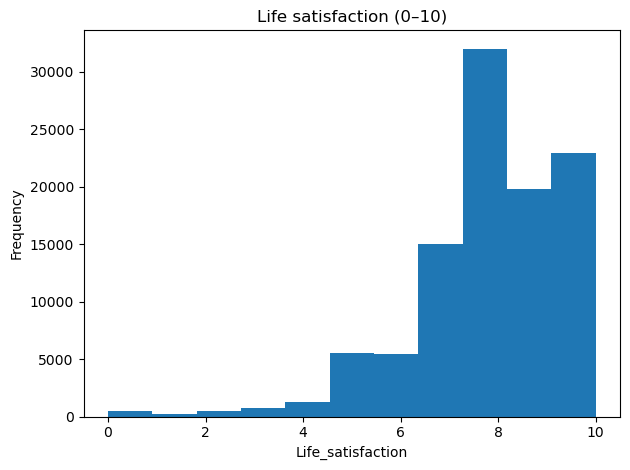

In [17]:
# Check distributions
if "Mental_health_label" in d2.columns:
    print("Mental_health_label")
    print(d2["Mental_health_label"].value_counts(dropna=False))
    print("\nMental_health_label_clean")
    print(d2["Mental_health_label_clean"].value_counts(dropna=False))

if "Life_satisfaction" in d2.columns:
    print("\nLife_satisfaction (raw)")
    print(d2["Life_satisfaction"].value_counts(dropna=False).sort_index().head(20))

if "Life_satisfaction_clean" in d2.columns:
    print("\nLife_satisfaction_clean (0-10 only, specials -> NaN)")
    print(d2["Life_satisfaction_clean"].describe())

    # Optional: distribution plot
    import matplotlib.pyplot as plt
    plt.figure()
    d2["Life_satisfaction_clean"].dropna().plot(kind="hist", bins=11)
    plt.title("Life satisfaction (0–10)")
    plt.xlabel("Life_satisfaction")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [18]:
special = df["Life_satisfaction"].isin([97, 98, 99]).sum()
total = df["Life_satisfaction"].shape[0]
print("Life_satisfaction special codes (97/98/99):", special, f"({special/total:.2%})")


Life_satisfaction special codes (97/98/99): 4200 (3.88%)


In [19]:
MAP_GENDER = {
    1: "Male",
    2: "Female",
    9: "Not stated",
}

UNKNOWN_CODES = {"Don't know", "Refusal", "Not stated", "Valid skip"}

d2["Gender_label"] = d2["Gender"].map(MAP_GENDER).astype("category")

# Optional: clean version for plots (drop "Not stated")
d2["Gender_label_clean"] = (
    d2["Gender_label"].astype("object")
      .where(~d2["Gender_label"].astype("object").isin(UNKNOWN_CODES), np.nan)
      .astype("category")
)



Gender_label_clean
Male      8.046552
Female    8.067027
Name: Life_satisfaction_clean, dtype: float64


/var/folders/k2/sngvkdcn2ydby0tvb60zn_p00000gn/T/ipykernel_33610/1385559764.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = tmp.groupby("Gender_label_clean")["Life_satisfaction_clean"].mean().sort_values()


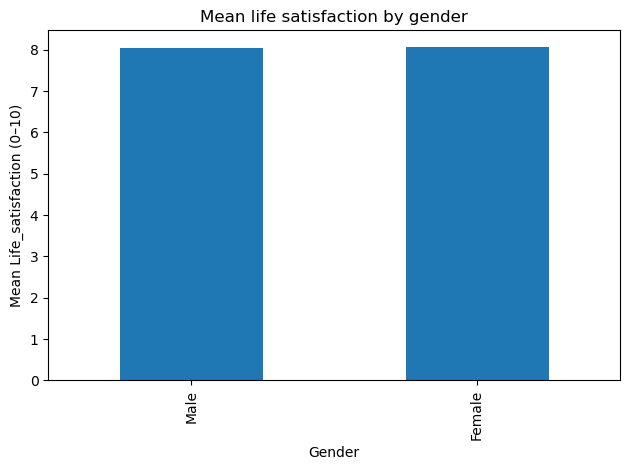

In [20]:
tmp = d2.dropna(subset=["Gender_label_clean", "Life_satisfaction_clean"])
means = tmp.groupby("Gender_label_clean")["Life_satisfaction_clean"].mean().sort_values()
print(means)

import matplotlib.pyplot as plt
plt.figure()
means.plot(kind="bar")
plt.title("Mean life satisfaction by gender")
plt.xlabel("Gender")
plt.ylabel("Mean Life_satisfaction (0–10)")
plt.tight_layout()
plt.show()


We mapped key coded variables (Age, Gender, Stress_level, Mental_health_state) to human-readable labels using the provided codebook. Non-substantive responses such as “Don’t know”, “Refusal”, and “Not stated” were standardized to NA in the corresponding “*_clean” fields to avoid misleading visualizations. For Life_satisfaction, special response codes (97/98/99) account for 4,200 responses (3.88%) and were removed in `Life_satisfaction_clean`, leaving a valid 0–10 scale with a median around 8. A simple feasibility check (mean life satisfaction by gender) confirms that subgroup aggregation and plotting are stable after cleaning, supporting the planned dashboard interactions and comparisons across demographic segments.
